- 新闻自动化处理:
新闻内容自动提取及呈现    
输入任意的新闻网址，对其进行：    
1）抓取正文内容，对非中文内容进行清洗    
2）文章关键词     
3）文章摘要，即关键句    
4）词云可视化     
新闻来源：https://3w.huanqiu.com/


考虑要自动化处理的需求，所以直接封装为类。

目前仍有不足的是缺少有效的词性字典，jieba自带的词性库不准确。

In [1]:
import re

import jieba
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from jieba import posseg as pseg

开始加载新闻......


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/zd/40qznnn95xd5900ww1_ygqrr0000gn/T/jieba.cache


新闻加载完毕！


Loading model cost 0.664 seconds.
Prefix dict has been built successfully.


该新闻中的人物有： {'贾森', '顾问', '封锁', '白宫', '高攀', '许缘', '布赖森', '马克', '熊茂伶', '弗曼', '鲍威尔'}
该新闻中的地点是： {'华盛顿', '美国'}
根据词频，开始生成词云!


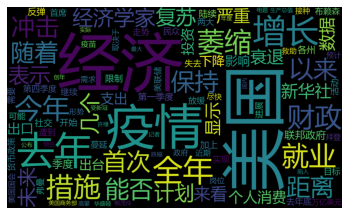

In [2]:
class MySpider:
    """
    用于爬取 国际新闻—环球独家 下的新闻，新闻ULR格式：https://world.huanqiu.com/article/XXXX
    """
    def __init__(self):
        self.header = {
            "user-agent":
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36"
        }

    def crawler(self, url):
        """爬取新闻正文内容"""
        print("开始加载新闻......")
        res = requests.get(url, headers=self.header)
        res.encoding = 'utf-8'
        contents = None
        if res.status_code == 200:
            soup = BeautifulSoup(res.text, "html.parser")
            # 定位"section"标签下的所有标签为p的tag
            contents = [tag.text for tag in soup.select("section p")]
            contents = "".join(contents)
            print("新闻加载完毕！")
        else:
            print(f"新闻加载遇到异常，状态码: {res.status_code}")
        return contents


class VisualNews:
    def __init__(self, article):
        self.stop_words = ['的', '了', '是', '月', '日']
        self.article = article
        self.get_name_and_place()

    def get_name_and_place(self):
        jieba.add_word("明显改善", tag='v')  # 副形词
        jieba.add_word("关键因素", tag='n')
        jieba.add_word("熊茂伶", tag='nr')
        jieba.add_word("布赖森", tag='nr')
        jieba.add_word("弗曼", tag='nr')
        words = pseg.lcut(self.article)
        names = {word for word, flag in words if flag == 'nr'}
        places = {word for word, flag in words if flag == 'ns'}
        print("该新闻中的人物有：", names)
        print("该新闻中的地点是：", places)

    def remove_stopwords(self, string):
        stop_words = self.stop_words
        for stop_word in stop_words:
            string = string.replace(stop_word, '')
        return string

    # 生成词云
    def create_word_cloud(self, max_words=100, sav_png="wordcloud.jpg"):
        print('根据词频，开始生成词云!')
        # 仅保留中文和标点符号
        contents = "".join(re.findall("[\u4e00-\u9fa5。，？！：]", self.article))
        contents = self.remove_stopwords(contents)
        cut_text = jieba.cut(contents)
        cut_text = " ".join(cut_text)
        wc = WordCloud(
            max_words=max_words,
            width=2000,
            height=1200,
            collocations=False,
            font_path='msyh.ttf',
        )
        wordcloud = wc.generate(cut_text)
        # 写词云图片
        wordcloud.to_file(sav_png)
        # 显示词云文件
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()


if __name__ == "__main__":
    URL = "https://world.huanqiu.com/article/41iWlHaX3ae"
    spider = MySpider()
    article = spider.crawler(URL)
    if article:
        visualize = VisualNews(article)
        visualize.create_word_cloud()